# Smart Meter Playbook

<p>
Mal Minhas, v0.3<br>
19.11.24
</p>
<p>
<h4>Versions</h4>
<ul>
<li><b>v0.1</b>: 14.07.24. First version</li>
<li><b>v0.2</b>: 16.11.24. Rerun with latest data</li>
<li><b>v0.3</b>: 19.11.24. Updated to include functions to fully handle start to end date range</li>
</ul>
</p>

### 1. Background

This playbook outlines a recipe for accessing your electricity data if you have a smart meter installed.  It builds on [information provided by Matt Brake on LinkedIn in August 2023](https://www.linkedin.com/pulse/how-access-gb-smart-meter-data-matt-brake/) on how different types of users can access GB smart meter data discusses and how consumers can manage and share their smart meter data. Key points from that article:
<ul>
<li><b>Data Storage and Access</b>: Smart meters store data on-site for up to 13 months.</li>
<li><b>Consumer Control</b> Consumers own their data and must give consent for others to access it.</li>
<li><b><a href="https://www.n3rgy.com">n3rgy Platform</a></b>: A company that provides an API to simplify data access while ensuring security and regulatory compliance.</li>
<li><b><a href="https://data.n3rgy.com/consumer/profile">n3rgy Consumer Portal</a></b>: A user interface on the llows users to control and view who accesses their data.</li>
</ul>
    
The UK smart meter network currently operating in Great Britain is run by the [Data Communications Company (DCC)](https://www.smartdcc.co.uk/)  The n3rgy service aims to break down barriers to access to smart meter data while maintaining high security standards.  There are three different types of users of smart meter data:
<ul>
<li><b>Core Users</b>: Retail energy suppliers and the energy (gas and electric) network operators. They use the data from the meters to bill consumers and manage our energy network.</li>
<li><b>Other Users</b>: Organisation interested in accessing smart meter data for other business purposes including data aggregration.</li>
<li><b>Consumers</b>: Homeowner or end user interested in how the system works.</li>
</ul>

This playbook focusses on Consumer users who already has a smart meter install.  In order to get started, you will need two pieces of information:
<ul>
<li><b>Meter Point Administration Number (MPAN)</b>: This is a 13-digit number you will find on your electricity bill or your smart meter.</li>
<li><b>In-Home Display (IHD) MAC</b>: This is a 16-digit alphanumeric ID you will find on your smart meter display unit.</li>
</ul>
The next section goes into a bit more detail as to how to determine them.

### 2. MPAN and IHD MAC

You can use a smart meter check such as the one provided by the [Citizen Advice Bureau](https://smartmetercheck.citizensadvice.org.uk/meters/new?fuel_type=electricity) to check the status of your smart meter with the DCC.  You will need your MPAN and postcode:

<div>
<img src="MPAN.png" width="600"/>  
</div>

Using that tool indicates that my smart meter is registered to work in smart mode so I should be able to access my data via an MSP such as n3rgy.

<div>
<img src="SmartMeterOk.png" width="600"/>  
</div>

Your IHD MAC you need to obtain from your in-home display unit.  You should be able to find it both on the outside of the unit and also by clicking through on the Menu to the IHD Information option.  [This article](https://www.equiwatt.com/help/where-do-i-find-the-mac/guid/eui-number-on-my-in-home-display-ihd ) provides some useful additional context if you are having any challenges on finding it.

It is also possible to use the [online smart meter checker provided by n3rgy](https://homebrew.n3rgy.com/) to provide more information on your smart meter.  The code below shows how to do that with a function that replicates what that form does.  Note that `HOUSE_NUMBER` and `POSTCODE` are stored in environment variables for the purposes of security.

In [1]:
import os
import requests

MPAN = os.environ.get('MPAN')
IHD_MAC = os.environ.get('IHD_MAC')
HOUSE_NUMBER = os.environ.get('HOUSE_NUMBER')
POSTCODE = os.environ.get('POSTCODE')

assert(MPAN and IHD_MAC and HOUSE_NUMBER and POSTCODE)

def checkMeter(house, postcode, confirm='on'):
    url = f"https://homebrew.n3rgy.com/cgi-bin/n3rgy-checkmeter.py?house={house}&postcode={postcode}&confirm={confirm}"
    headers = {'Authorization': MPAN}
    r = requests.get(url=url, headers=headers)
    assert(r.status_code == 200)
    return r.text

html = checkMeter(HOUSE_NUMBER, POSTCODE, confirm='on')

The endpoint here runs a CGI script that generates the response in HTML we can parse using `BeautifulSoup` as follows:

In [2]:
%%time
try: 
    from BeautifulSoup import BeautifulSoup
except ImportError:
    from bs4 import BeautifulSoup

def generateSmartMeterReport(html):
    parsed_html = BeautifulSoup(html)
    title = parsed_html.find_all("body")[1].find("h2").string
    raw_headings = parsed_html.find_all("body")[1].find_all("pre")[0].find_all("b")
    headings = [heading.string for heading in raw_headings]
    values = str(parsed_html.find_all("body")[1].find_all("pre")[0]).split('\n')
    report = f"{title}\n====================\n\n"
    i = 0
    for v in values:
        if v not in ['<pre>','</pre>']:
            if v.find('<b>') == 0:
                report += f"{headings[i]}\n-----------------\n"
                i += 1
            else:
                report += f"{v}\n"
    return report

report = generateSmartMeterReport(html)

CPU times: user 40.9 ms, sys: 8.17 ms, total: 49 ms
Wall time: 58.1 ms


The report is not printed in full here because it contains sensitive information but here's a sample from it:

In [3]:
print(report[52:170] +  '...\n' + report[350:468] + '...\n\n' +  report[1268:1522])

Communications Device
-----------------
Device Type: CHF
Manufacturer: WNC [1072]
Model: unknown [57310102]
GUID: 00-0...

Electricity Meter
-----------------
Device Type: ESME
Manufacturer: SECURE [1031]
Model: unknown [A0A1013D]
GUID: B8-...

In-Home-Display
-----------------
Device Type: PPMID
Manufacturer: CHAMELEON [10E0]
Model: unknown [00210001]
Installed: 2023-11-07
Firmware Certified: 01/12/2022
Firmware Age: 2 [00010102] (number of newer versions available)
Security Expiry Date: None



### 3. n3rgy API Basics

To access energy consumption data you need to first sign up as a consumer at the n3rgy portal sign up page [here](https://data.n3rgy.com/consumer-sign-up).  You will need to enter your `MPAN` and `IDH MAC` per the previous section and provide your consent as a Consumer to n3rgy to allow them to access and store your smart meter data.   Once you have done that you will be able to access your data either by direct download on their consumer portal as a csv or via an API.  The [recipe provided by n3rgy in Github](https://github.com/n3rgy/consumer-data) doesn't really make clear what needs to go into the API call and the example doesn't show any parameters.  After inspecting what happens in the web browser in the [consumer portal](https://data.n3rgy.com/consumer/download-data) when you download your data as a csv, the structure of the url needed to download consumption data becomes apparent:

<div>
<img src="DebuggingConsumerPortal.png" width="1200"/>  
</div>

You are required to provide your `IHD_MAC` in your auth header for the API call.  The following code demonstrates how to retrieve the last three months of electricity data at the time of writing.  Note this code assumes you have set up a local environment variable `IHD_MAC`which contains your IDH MAC value.  You only seem to be able to get three months of data in one call.  Any more than that results in a 206 partial data error.  We can pull the data for the available cache range.  Let's write a function called `getDataInRange` to do that together with some utility functions for manipulating date strings. 

In [4]:
import arrow

def getDate(date_str='', dayOffset=0, monthOffset=0):
    ''' Getting today's date and formatting it as DD.MM.YYYY '''
    start = arrow.now().floor('day')
    if date_str: 
        start = arrow.get(date_str, "DD.MM.YYYY")
    return start.shift(days=dayOffset, months=monthOffset).format("DD.MM.YYYY")

def isDateLessThanToday(date_str):
    ''' Checks if the given date is earlier than today's date. '''
    given_date = arrow.get(date_str, "DD.MM.YYYY")
    today = arrow.now().floor('day')
    return given_date < today
    
def getAvailableRange(start, end, source='electricity', category='consumption', fmt='json'): 
    reformatDate = lambda s: ''.join(s.split('.')[::-1])
    start = reformatDate(start)
    end = reformatDate(end)
    url = f"https://consumer-api.data.n3rgy.com/{source}/{category}/1?start={start}&end={end}&output={format}"
    headers = {'Authorization': IHD_MAC}
    r = requests.get(url=url, headers=headers)
    assert(r.status_code == 200)
    d = r.json().get('availableCacheRange')
    start = d.get('start')
    start = f"{start[6:8]}.{start[4:6]}.{start[:4]}"
    end = d.get('end')
    end = f"{end[6:8]}.{end[4:6]}.{end[:4]}"
    return start, end

def getDataInRange(start, end, source='electricity', category='consumption', fmt='json'):
    reformatDate = lambda s: ''.join(s.split('.')[::-1])
    start = reformatDate(start)
    end = reformatDate(end)
    url = f"https://consumer-api.data.n3rgy.com/{source}/{category}/1?start={start}&end={end}&output={format}"
    headers = {'Authorization': IHD_MAC}
    r = requests.get(url=url, headers=headers)
    assert(r.status_code == 200)
    return r.json()

Let's test those utility functions for working with date strings are operating as expected:

In [5]:
today = getDate()
yesterday = getDate(dayOffset=-1)
tomorrow = getDate(dayOffset=1)
assert(not isDateLessThanToday(today))
assert(isDateLessThanToday(yesterday))
assert(getDate(yesterday,0,0) == yesterday)
assert(getDate(yesterday,2,0) == tomorrow)
threeMonthsFromNow = getDate(monthOffset=3)
assert(not isDateLessThanToday(threeMonthsFromNow))
threeMonthsAgoFromNow = getDate(monthOffset=-3)
assert(isDateLessThanToday(threeMonthsAgoFromNow))

start,end = getAvailableRange(yesterday, today)
print(f"Today is {today} and yesterday was {yesterday}. We can get energy data from start={start} to end={end}")

Today is 19.11.2024 and yesterday was 18.11.2024. We can get energy data from start=07.12.2023 to end=18.11.2024


Now lets populate two arrays `starts` and `ends` with three month blocks from `start` to `end` making sure the last block only runs up to `today`.  The function `generateDateBlocks` will do that for us:

In [6]:
def generateDateBlocks(moffset=3):
    starts = []
    ends = []
    offset = start
    while isDateLessThanToday(offset):
        starts.append(offset)
        noffset = getDate(offset, dayOffset=-1, monthOffset=moffset)
        if isDateLessThanToday(noffset):    
            offset = getDate(noffset, dayOffset=1)
        else:
            noffset = today
            offset = today
        ends.append(noffset)
    return starts, ends

starts,ends = generateDateBlocks(moffset=3)
print(f"Start dates: {starts}")
print(f"End dates  : {ends}")

Start dates: ['07.12.2023', '07.03.2024', '07.06.2024', '07.09.2024']
End dates  : ['06.03.2024', '06.06.2024', '06.09.2024', '19.11.2024']


We can now use these two arrays `starts` and `ends` in combination with `getDataInRange` to get all electricity data between `start` and `end` as follows:

In [7]:
results = []
for s,e in zip(starts, ends):
    records = getDataInRange(s, e, source='electricity')
    print(f"{len(records.get('values'))} records found between {s} and {e}")
    results.append(records)

4320 records found between 07.12.2023 and 06.03.2024
4368 records found between 07.03.2024 and 06.06.2024
4368 records found between 07.06.2024 and 06.09.2024
3461 records found between 07.09.2024 and 19.11.2024


Let's print the keys for the response data.  Note that our values are in `d.get('values')`:

In [8]:
d = results[0]
print("-------------------------------")
print(f"keys = {list(d.keys())}")
print(f"resource = {d.get('resource')}")
print(f"responseTimestamp = {d.get('responseTimestamp')}")
print(f"start = {d.get('start')}")
print(f"end = {d.get('end')}")
print(f"granularity = {d.get('granularity')}")
print(f"{len(d.get('values'))} values")
print(f"availableCacheRange = {d.get('availableCacheRange')}")
print(f"unit = {d.get('unit')}")

-------------------------------
keys = ['resource', 'responseTimestamp', 'start', 'end', 'granularity', 'values', 'availableCacheRange', 'unit']
resource = /electricity/consumption/1
responseTimestamp = 2024-11-19T00:33:52.125Z
start = 202312070030
end = 202403060000
granularity = halfhour
4320 values
availableCacheRange = {'start': '202312070000', 'end': '202411180230'}
unit = kWh


### 4. Visualising electricity consumption data

Let's create a unified values array `all_values` and stick it into in a `pandas` dataframe.

In [9]:
import pandas as pd

all_values = []
for d in results:
    all_values += d.get('values')
df = pd.DataFrame(all_values)

Let's print the top 5 values for a tweaked version of the data frame, `df2`, that has the timestamps converted to `datetime` values and also has the right units for the values:

In [10]:
def tweak_df(df):
    ts = pd.to_datetime(df.timestamp)
    return (df
            .rename(columns={'value':d.get('unit') or 'value'})
            .assign(timestamp=ts)
            .set_index('timestamp')
           )

df2 = tweak_df(df)
df2.head(5)

,kWh
timestamp,
2023-12-07 00:30:00,0.125
2023-12-07 01:00:00,0.244
2023-12-07 01:30:00,0.072
2023-12-07 02:00:00,0.075
2023-12-07 02:30:00,0.067


We can now plot the raw kWh values as a time series over the last three months:

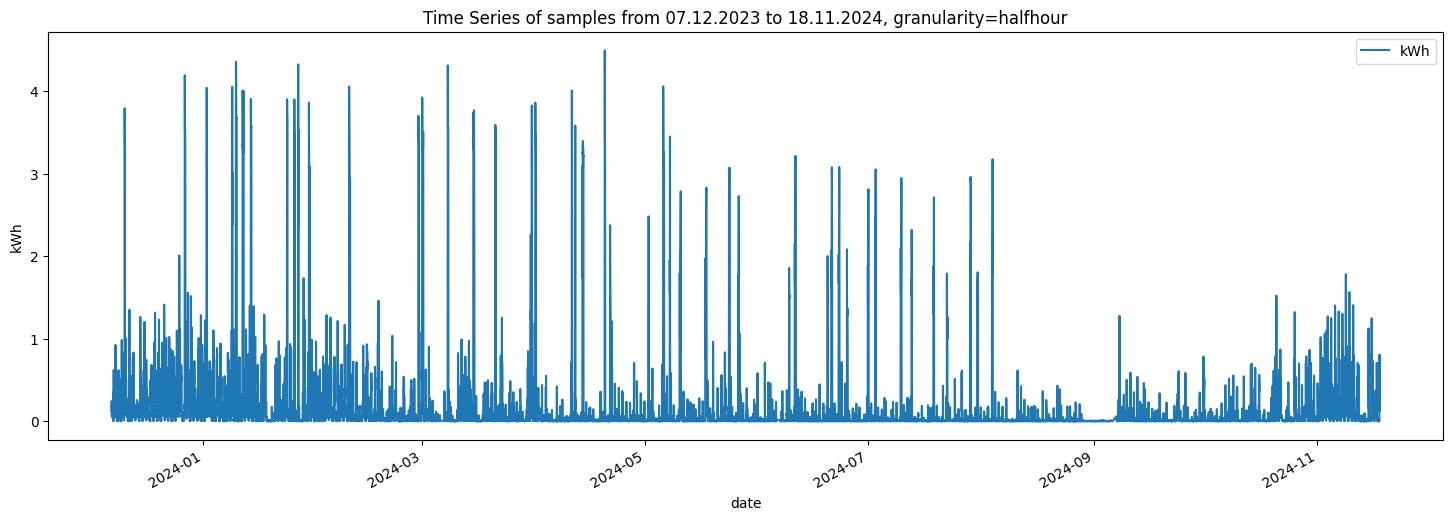

In [11]:
_ = df2.plot(figsize=(18,6), title=f"Time Series of samples from {start} to {end}, granularity={d.get('granularity')}", xlabel='date', ylabel='kWh')

The data here makes sense with the period up to 08-2024 corresponding to having an EV being charged at home. 

The following function resamples the data to allow us to batch and look at daily, weekly, monthly or yearly kWh sums. Note that the [ChatGPT Python GPT was used to assist with tweaking the formatting of the `plotResampledTimeSeries` function](https://chatgpt.com/share/f82b0653-8a6f-4bf4-9b8a-73fdbc2274f2):

In [12]:
def plotResampledTimeSeries(period, angle, show_x_axis=True):
    df2_resampled = df2.resample(period).sum()
    # Plotting the resampled data
    ax = df2_resampled.plot(kind='bar', figsize=(18, 6), title=f"Time Series of samples from {start} to {end}, granularity={period}", xlabel='date', ylabel='kWh')
    if show_x_axis:
        # Formatting the x-axis to show only dates
        #ax.set_xticklabels(df2_resampled.index.strftime('%Y-%m-%d'), rotation=angle, ha='right')
        if angle >= 70 and angle <=120:
            ax.set_xticklabels(df2_resampled.index.strftime('%d-%m-%Y'), rotation=angle, ha='center', va='top')
        elif angle < 70:
            ax.set_xticklabels(df2_resampled.index.strftime('%d-%m-%Y'), rotation=angle, ha='right', va='top')
        elif angle > 120:
            ax.set_xticklabels(df2_resampled.index.strftime('%d-%m-%Y'), rotation=angle, ha='left', va='top')
    else:
        ax.tick_params(axis='x', which='both', labelbottom=False)  # Removes tick labels
        ax.set_xlabel('')  # Removes the label
    # Extend the y-axis to create more space at the top
    y_max = df2_resampled.max().values[0]
    ax.set_ylim(0, y_max * 1.1)
    # Annotating the bar values at the top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{round(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

The first plot will batch by start of month (`D`) over the time series:

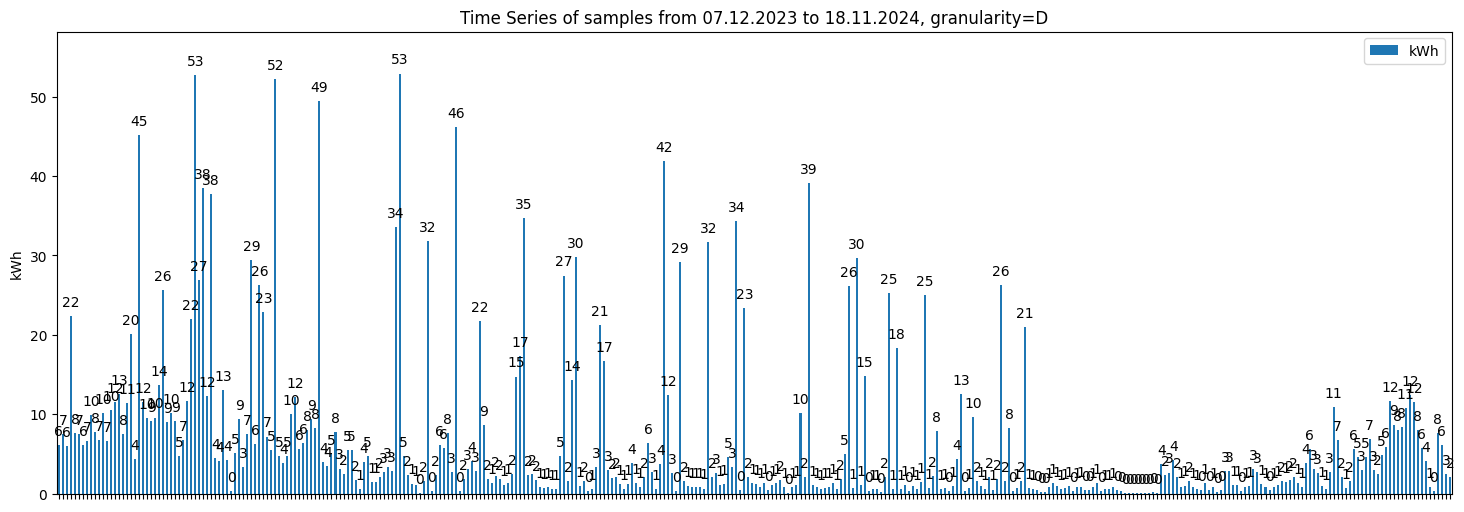

In [13]:
plotResampledTimeSeries(period='D', angle=85, show_x_axis=False)

Let's see what this adds up to in terms of start of month (`MS`) consumption over the period:

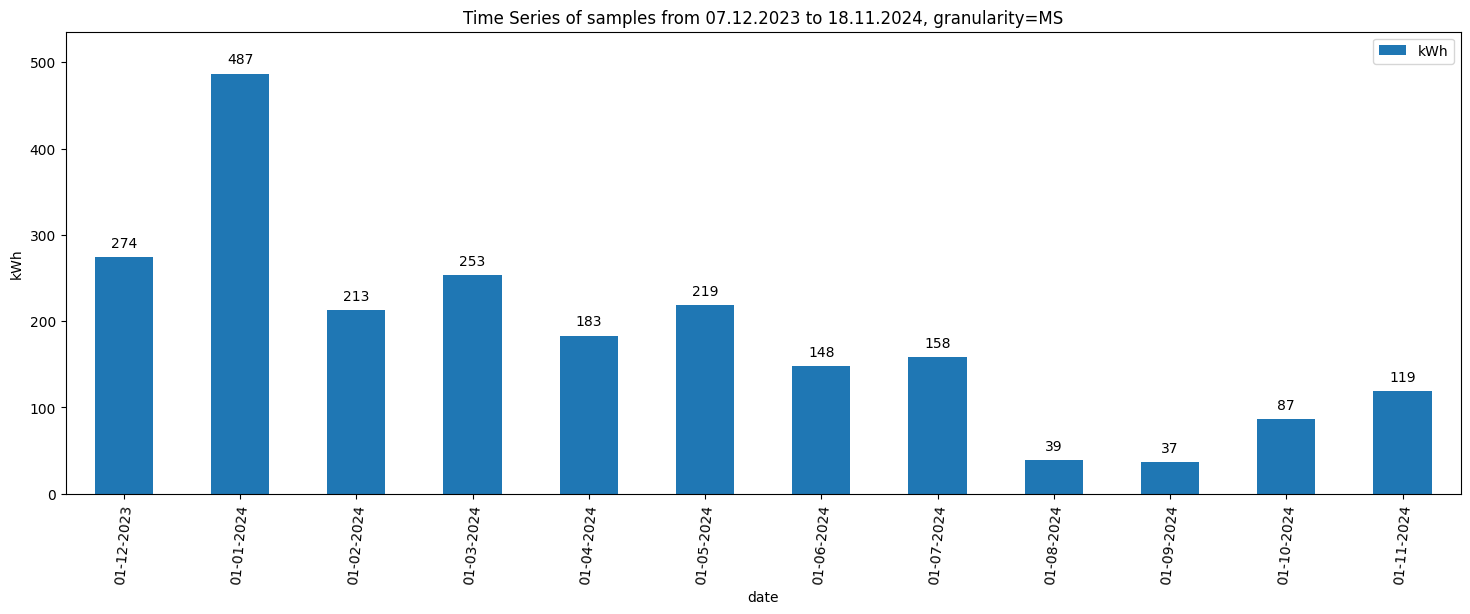

In [14]:
plotResampledTimeSeries(period='MS', angle=85)

### 5. Obtaining tariff data

From Googling around [this Medium article](https://medium.com/@richardr39/n3rgy-dotnet-a-net-tool-for-retrieving-n3rgy-smart-meter-data-in-the-uk-53505d78a4cc) outlines one other method on the n3rgy API namely `tariff`.  The [corresponding C# code in Github](https://github.com/rars/n3rgy-dotnet) highlights how to invoke it using the functions already created above.  The code below illustrates how to plot the tariff values as a time series.  In this case they are constant over the last day prior to running the script.

21.08.2024 19.11.2024


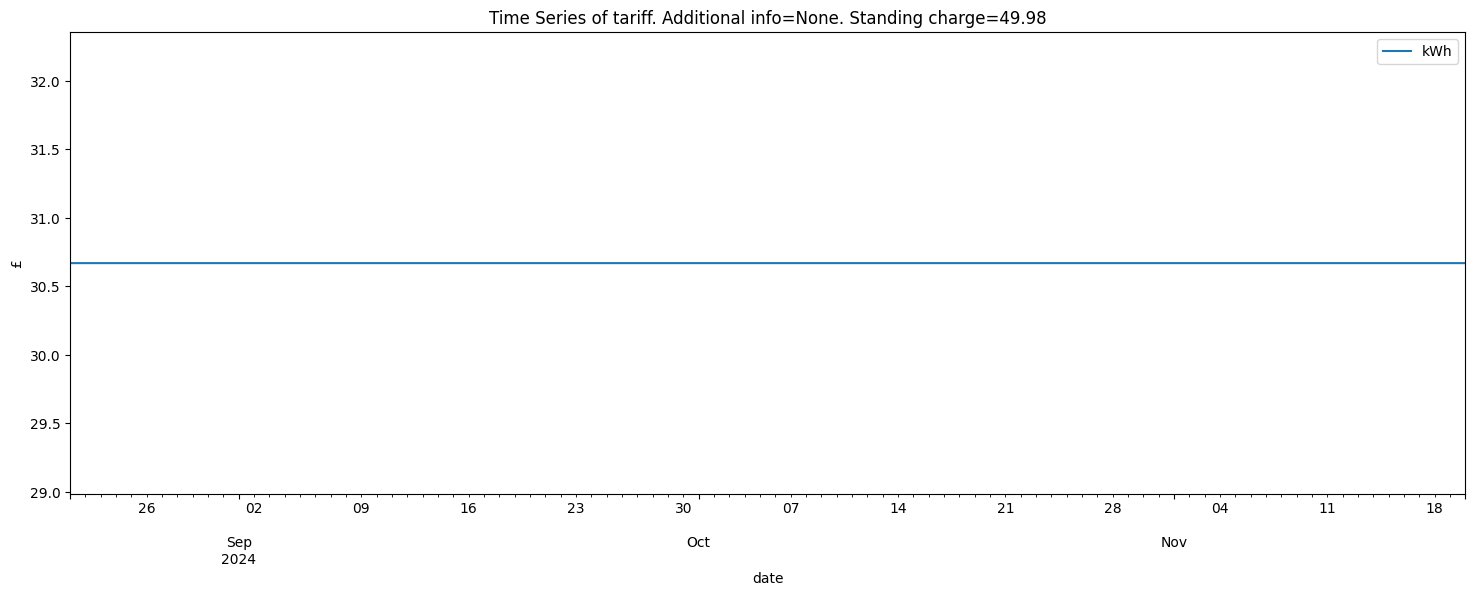

In [15]:
threeMonthsAgo = getDate(dayOffset=2, monthOffset=-3)
print(threeMonthsAgo,today)
d1 = getDataInRange(threeMonthsAgo, today, category='tariff')
additionalInfo = d1.get('values')[0].get('additionalInformation')
standingCharges = dict(d1.get('values')[0].get('standingCharges')[0])
prices = d1.get('values')[0].get('prices')
standingCharge = standingCharges.get('value')
df3 = pd.DataFrame(prices)
df4 = tweak_df(df3)
_ = df4.plot(figsize=(18,6), title=f"Time Series of tariff. Additional info={additionalInfo}. Standing charge={standingCharge}", xlabel='date', ylabel='£')

HAN here stands for <b>Home Area Network</b> which connects a smart meter to devices around your home such as the IHD.  You can read more about [here](https://www.ofgem.gov.uk/sites/default/files/docs/2010/12/han-workshop---19-nov---ember-han-basics_0.pdf).

<div>
<img src="HAN.png" width="600"/>
</div>